## Importing the Required Dependencies

In [84]:
# Import Python Standard Library dependencies
import datetime
from functools import partial
from glob import glob
import json
import math
import multiprocessing
import os
from pathlib import Path
import random

# Import utility functions
from cjm_psl_utils.core import download_file, file_extract
from cjm_pil_utils.core import resize_img, get_img_files, stack_imgs
from cjm_pytorch_utils.core import tensor_to_pil, get_torch_device, set_seed, denorm_img_tensor
from cjm_pandas_utils.core import markdown_to_pandas, convert_to_numeric, convert_to_string
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop, CustomRandomAugment

# Import YOLOX package
from cjm_yolox_pytorch.model import build_model, MODEL_CFGS, NORM_STATS
from cjm_yolox_pytorch.utils import generate_output_grids
from cjm_yolox_pytorch.loss import YOLOXLoss
from cjm_yolox_pytorch.inference import YOLOXInferenceWrapper

# Import the distinctipy module
from distinctipy import distinctipy

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Do not truncate the contents of cells and display all rows and columns
pd.set_option('max_colwidth', None, 'display.max_rows', None, 'display.max_columns', None)

# Import PIL for image manipulation
from PIL import Image

# Import PyTorch dependencies
import torch
from torch.amp import autocast
from torch.cuda.amp import GradScaler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtnt.utils import get_module_summary

# Import torchvision dependencies
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.v2  as transforms
from torchvision.transforms.v2 import functional as TF

# Import tqdm for progress bar
from tqdm.auto import tqdm

## Setting Up the Project

### Setting a Random Number Seed

In [85]:
# Set the seed for generating random numbers in PyTorch, NumPy, and Python's random module.
seed = 1234
set_seed(seed)

### Setting the Device and Data Type

In [86]:
device = get_torch_device()
dtype = torch.float32
device, dtype

('cuda', torch.float32)

### Setting the Directory Paths

In [87]:
# The name for the project
project_name = f"pytorch-yolox-object-detector"
dataset_path =  Path('dataset/training')
# The path for the project folder
project_dir = Path(f"./{project_name}/")

# Create the project directory if it does not already exist
project_dir.mkdir(parents=True, exist_ok=True)


# Define path to store archive files
archive_dir = Path("./Archive")
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)

pd.Series({
    "Project Directory:": project_dir, 
    "Archive Directory:": archive_dir
}).to_frame().style.hide(axis='columns')

Project Directory:,pytorch-yolox-object-detector
Archive Directory:,Archive


## Loading and Exploring the Dataset

### Getting the Image and Annotation Folders

In [88]:
# Create a list of the items in the 'dataset_path' directory
dir_content = [item for item in dataset_path.iterdir() if item.is_dir()]

# Get the path of the 'ann_train_val' directory
annotation_dir = dataset_path/'json'

# Remove the 'ann_train_val' directory from the list of items
dir_content.remove(annotation_dir)

# Get the path of the remaining directory, which is assumed to be the image directory
img_dir = dir_content[0]

# Print the paths of the annotation and image directories
print(f"Annotation Directory: {annotation_dir}")
print(f"Image Directory: {img_dir}")

# Get a list of files in the 'annotation_dir' directory
annotation_file_paths = list(annotation_dir.glob('*.json'))

# Get a list of folders in the 'img_dir' directory
img_folder_paths = [folder for folder in img_dir.iterdir() if folder.is_dir()]

# Display the names of the folders using a Pandas DataFrame
pd.DataFrame({"Image Folder": [folder.name for folder in img_folder_paths], 
              "Annotation File":[file.name for file in annotation_file_paths]})

Annotation Directory: dataset\training\json
Image Directory: dataset\training\plus


,Image Folder,Annotation File
0,A,A.json
1,B,B.json
2,C,C.json
3,D,D.json
4,E,E.json
5,F,F.json
6,G,G.json
7,H,H.json
8,I,I.json
9,J,J.json


### Get Image File Paths

In [89]:
# Get all image files in the 'img_dir' directory
img_dict = {
    file.stem : file # Create a dictionary that maps file names to file paths
    for folder in img_folder_paths # Iterate through each image folder
    for file in get_img_files(folder) # Get a list of image files in each image folder
}

# Print the number of image files
print(f"Number of Images: {len(img_dict)}")

# Display the first five entries from the dictionary using a Pandas DataFrame
pd.DataFrame.from_dict(img_dict, orient='index').head()

Number of Images: 121769


,0
A_left_A1,dataset\training\plus\A\A_left_A1.jpg
A_left_A1000,dataset\training\plus\A\A_left_A1000.jpg
A_left_A1001,dataset\training\plus\A\A_left_A1001.jpg
A_left_A1002,dataset\training\plus\A\A_left_A1002.jpg
A_left_A1003,dataset\training\plus\A\A_left_A1003.jpg


### Get Bounding Box Annotations

In [90]:
# Set the file path for the annotations DataFrame
annotation_df_pq_path = dataset_path/'annotations_df.parquet'

if annotation_df_pq_path.is_file():
    # Load the annotations DataFrame if present
    annotation_df = pd.read_parquet(annotation_df_pq_path)
else:
    # Create a generator that yields Pandas DataFrames containing the data from each JSON file
    cls_dataframes = (pd.read_json(f).transpose() for f in tqdm(annotation_file_paths))

    # Concatenate the DataFrames into a single DataFrame
    annotation_df = pd.concat(cls_dataframes, ignore_index=False)

    # Keep only the rows that correspond to the filenames in the 'img_dict' dictionary
    annotation_df = annotation_df.loc[list(img_dict.keys())]

    # Save the annotations DataFrame to disk
    annotation_df.to_parquet(annotation_df_pq_path)

# Print the first 5 rows of the DataFrame
annotation_df.head()

  0%|          | 0/26 [00:00<?, ?it/s]

,bboxes,labels,leading_hand
A_left_A1,"[[0.31, 0.14, 0.39, 0.48]]",[A],Left
A_left_A1000,"[[0.105, 0.32, 0.28500000000000003, 0.385]]",[A],Left
A_left_A1001,"[[0.06, 0.22, 0.43, 0.5750000000000001]]",[A],Left
A_left_A1002,"[[0.05, 0.23, 0.43, 0.58]]",[A],Left
A_left_A1003,"[[0.035, 0.245, 0.445, 0.5700000000000001]]",[A],Left


### Inspecting the Class Distribution

#### Get image classes

In [91]:
# Get the number of samples for each object class
class_counts = annotation_df['labels'].explode().value_counts()

# Get a list of unique labels in the 'annotation_df' DataFrame
class_names = class_counts.index.tolist()

# Display the labels and the corresponding number of samples using a Pandas DataFrame
pd.DataFrame(class_counts)

,count
labels,
F,5750
K,5426
J,5227
Y,5185
S,5147
R,5122
V,5116
L,5089
U,5041


#### Visualize the class distribution

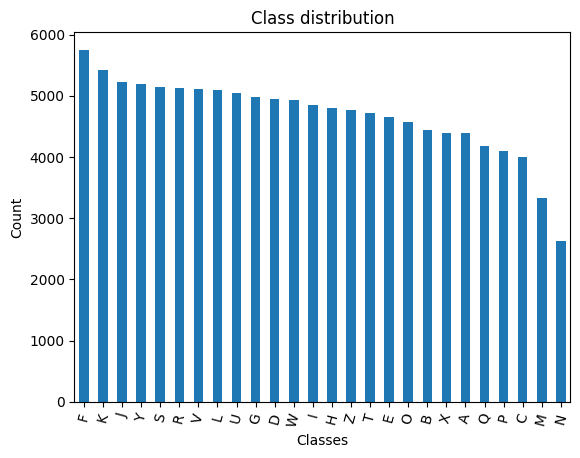

In [92]:
# Plot the distribution
class_counts.plot(kind='bar')
plt.title('Class distribution')
plt.ylabel('Count')
plt.xlabel('Classes')
plt.xticks(range(len(class_counts.index)), class_counts.index, rotation=75)  # Set the x-axis tick labels
plt.show()

### Visualizing Bounding Box Annotations

#### Generate a color map

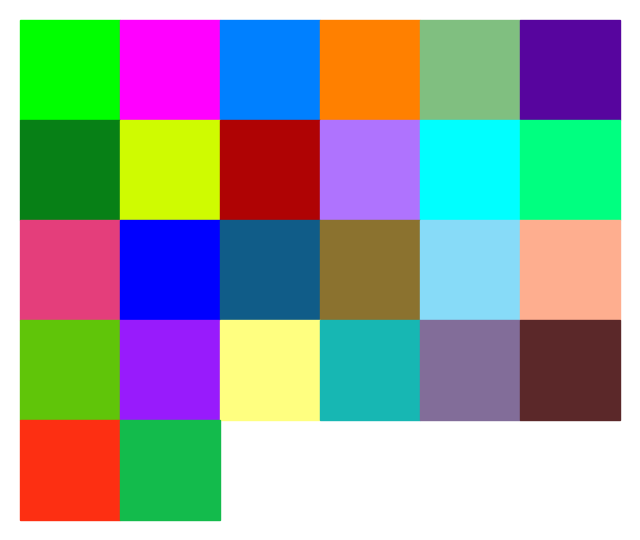

In [93]:
# Generate a list of colors with a length equal to the number of labels
colors = distinctipy.get_colors(len(class_names))

# Make a copy of the color map in integer format
int_colors = [tuple(int(c*255) for c in color) for color in colors]

# Generate a color swatch to visualize the color map
distinctipy.color_swatch(colors)

#### Download a font file

In [94]:
# Set the name of the font file
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'

# Download the font file
download_file(f"https://fonts.gstatic.com/s/roboto/v30/{font_file}", "./")

The file ./KFOlCnqEu92Fr1MmEU9vAw.ttf already exists and overwrite is set to False.


#### Define the bounding box annotation function

In [95]:
draw_bboxes = partial(draw_bounding_boxes, fill=False, width=2, font=font_file, font_size=25)

### Selecting a Sample Image

#### Load the sample image

Image Dims: (200, 200)


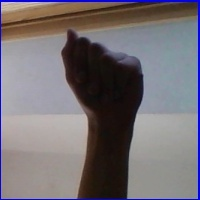

In [96]:
# Get the file ID of the first image file
file_id = list(img_dict.keys())[0]

# Open the associated image file as a RGB image
sample_img = Image.open(img_dict[file_id]).convert('RGB')

# Print the dimensions of the image
print(f"Image Dims: {sample_img.size}")

# Show the image
sample_img

#### Inspect the corresponding annotation data

In [97]:
# Get the row from the 'annotation_df' DataFrame corresponding to the 'file_id'
annotation_df.loc[file_id].to_frame()

,A_left_A1
bboxes,"[[0.31, 0.14, 0.39, 0.48]]"
labels,[A]
leading_hand,Left


#### Annotate sample image

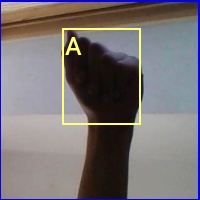

In [98]:
# Extract the labels and bounding box annotations for the sample image
labels = annotation_df.loc[file_id]['labels']
bboxes = annotation_df.loc[file_id]['bboxes']

# Calculate the bounding boxes in the image size scale
width, height = sample_img.size
bboxes = [[x*width, y*height, w*width, h*height] for x, y, w, h in bboxes]

# Annotate the sample image with labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=transforms.PILToTensor()(sample_img), 
    boxes=torchvision.ops.box_convert(torch.Tensor(bboxes), 'xywh', 'xyxy'), 
    labels=labels, 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

tensor_to_pil(annotated_tensor)

## Selecting a Model

### Exploring Available Models

In [99]:
pd.DataFrame(MODEL_CFGS).transpose()

,deepen_factor,widen_factor,neck_in_channels,neck_out_channels,neck_num_csp_blocks,head_in_channels,head_feat_channels
yolox_tiny,0.33,0.375,"[96, 192, 384]",96,1,96,96
yolox_s,0.33,0.5,"[128, 256, 512]",128,1,128,128
yolox_m,0.67,0.75,"[192, 384, 768]",192,2,192,192
yolox_l,1.0,1.0,"[256, 512, 1024]",256,3,256,256
yolox_x,1.33,1.25,"[320, 640, 1280]",320,4,320,320


### Loading the YOLOX-Tiny Model

In [100]:
# Select the YOLOX model configuration
model_type = 'yolox_tiny'
# model_type = 'yolox_s'
# model_type = 'yolox_m'
# model_type = 'yolox_l'
# model_type = 'yolox_x'

# Set whether to initialize the model with pretrained weights
pretrained = True

# Create a YOLOX model with the number of output classes equal to the number of class names
model = build_model(model_type, len(class_names), pretrained=pretrained).to(device=device, dtype=dtype)

# Add attributes to store the device and model name for later reference
model.device = device
model.name = model_type

# Get stride values for processing output
strides = model.bbox_head.strides

  0%|          | 0.00/20.5M [00:00<?, ?iB/s]

### Get Normalization Statistics

In [101]:
# Retrieve normalization statistics (mean and std) specific to the pretrained checkpoints
norm_stats = [*NORM_STATS[model_type].values()] if pretrained else ([0.5]*3, [1.0]*3)

# Print the mean and standard deviation
pd.DataFrame(norm_stats)

,0,1,2
0,0.5,0.5,0.5
1,1.0,1.0,1.0


### Summarizing the Model

In [102]:
# Define the input to the model
backbone_inp = torch.randn(1, 3, 256, 256).to(device)
with torch.no_grad(): neck_inp = model.backbone(backbone_inp)
with torch.no_grad(): head_inp = model.neck(neck_inp)

# Get a summary of the model as a Pandas DataFrame
backbone_summary = markdown_to_pandas(f"{get_module_summary(model.backbone, [backbone_inp])}").iloc[0]
neck_summary = markdown_to_pandas(f"{get_module_summary(model.neck, [neck_inp])}").iloc[0]
head_summary = markdown_to_pandas(f"{get_module_summary(model.bbox_head, [head_inp])}").iloc[0]
summary_df = pd.concat([backbone_summary, neck_summary, head_summary], axis=1).transpose()

parameters_df = summary_df['# Parameters'].apply(convert_to_numeric)
trainable_parameters = summary_df['# Trainable Parameters'].apply(convert_to_numeric)
size_df = summary_df['Size (bytes)'].apply(convert_to_numeric)
forward_flops_df = summary_df['Forward FLOPs'].apply(convert_to_numeric)

# compute sums and add a new row
total_row = {'Type': f'{model_type}',
             '# Parameters': convert_to_string(parameters_df.sum()),
             '# Trainable Parameters': convert_to_string(trainable_parameters.sum()),
             'Size (bytes)': convert_to_string(size_df.sum()),
             'Forward FLOPs': convert_to_string(forward_flops_df.sum()), 
             'In size': backbone_summary['In size'], 
             'Out size': head_summary['Out size']}

summary_df = pd.concat([pd.DataFrame([total_row]), summary_df], ignore_index=True)

# Remove extra columns
summary_df.drop(['In size', 'Out size', 'Contains Uninitialized Parameters?'], axis=1)

c:\Users\ntrantrong\AppData\Local\anaconda3\envs\pytorch-env\lib\site-packages\torchtnt\utils\module_summary.py:271: UserWarning: Backward FLOPs are only computed if module foward returns a tensor.
  warnings.warn(


,Type,# Parameters,# Trainable Parameters,Size (bytes),Forward FLOPs
0,yolox_tiny,5.1 M,5.1 M,20.2 M,1.206 G
1,CSPDarknet,2.4 M,2.4 M,9.5 M,500 M
2,YOLOXPAFPN,1.7 M,1.7 M,6.7 M,257 M
3,YOLOXHead,1.0 M,1.0 M,4.0 M,449 M


## Preparing the Data

### Training-Validation Split

In [103]:
# Get the list of image IDs
img_keys = list(img_dict.keys())

# Shuffle the image IDs
random.shuffle(img_keys)

# Define the percentage of the images that should be used for training
train_pct = 0.9
val_pct = 0.1

# Calculate the index at which to split the subset of image paths into training and validation sets
train_split = int(len(img_keys)*train_pct)
val_split = int(len(img_keys)*(train_pct+val_pct))

# Split the subset of image paths into training and validation sets
train_keys = img_keys[:train_split]
val_keys = img_keys[train_split:]

# Print the number of images in the training and validation sets
pd.Series({
    "Training Samples:": len(train_keys),
    "Validation Samples:": len(val_keys)
}).to_frame().style.hide(axis='columns')

Training Samples:,109592
Validation Samples:,12177


### Data Augmentation

#### Set training image size

In [104]:
# Show a list of potential input resolutions
print([max(strides)*i for i in range(7,21)])

# Set training image size to a multiple of the max stride value
train_sz = 384

[224, 256, 288, 320, 352, 384, 416, 448, 480, 512, 544, 576, 608, 640]


#### Initialize the transforms

In [105]:
fill = (0,0,0)
# fill = (123, 117, 104)

random_aug_tfm = CustomRandomAugment()

# Create a RandomIoUCrop object
iou_crop = CustomRandomIoUCrop(min_scale=0.3, 
                               max_scale=1.0, 
                               min_aspect_ratio=0.5, 
                               max_aspect_ratio=2.0, 
                               sampler_options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                               trials=400
                              )
iou_crop.fill = fill

# Create a `ResizeMax` object
resize_max = ResizeMax(max_sz=train_sz)

# Create a `PadSquare` object
pad_square = PadSquare(shift=True, fill=fill)

#### Test the transforms

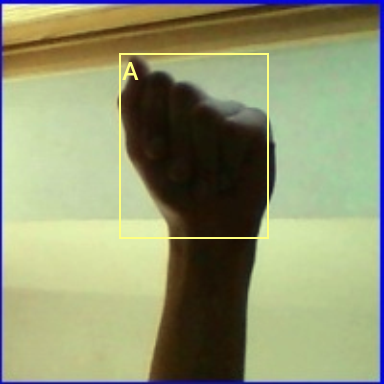

Source Image:,"(200, 200)"
Cropped Image:,"(200, 200)"
Resized Image:,"(384, 384)"
Padded Image:,"(384, 384)"
Resized Padded Image:,"(384, 384)"


In [106]:
# Prepare bounding box targets
targets = {'boxes': BoundingBoxes(torchvision.ops.box_convert(torch.Tensor(bboxes), 'xywh', 'xyxy'), 
                                format='xyxy', 
                                canvas_size=sample_img.size[::-1]), 
           'labels': labels}

# Crop the image
cropped_img, targets = iou_crop(sample_img, targets)

# Augment the image
augmented_img, targets = random_aug_tfm(cropped_img, targets)

# Resize the image
resized_img, targets = resize_max(augmented_img, targets)

# Pad the image
padded_img, targets = pad_square(resized_img, targets)

# Ensure the padded image is the target size
resize = transforms.Resize([train_sz] * 2, antialias=True)
resized_padded_img, targets = resize(padded_img, targets)

# Annotate the augmented image with updated labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=transforms.PILToTensor()(resized_padded_img), 
    boxes=targets['boxes'], 
    labels=targets['labels'], 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

# Display the annotated image
display(tensor_to_pil(annotated_tensor))

pd.Series({
    "Source Image:": sample_img.size,
    "Cropped Image:": cropped_img.size,
    "Resized Image:": resized_img.size,
    "Padded Image:": padded_img.size,
    "Resized Padded Image:": resized_padded_img.size,
}).to_frame().style.hide(axis='columns')

### Training Dataset Class

In [107]:
from windows_utils import HagridDataset

### Image Transforms

In [108]:
# Compose transforms for data augmentation
data_aug_tfms = transforms.Compose(
    transforms=[
        transforms.RandomChoice([
            transforms.RandomZoomOut(fill=fill, side_range=(1.125, 1.5)), 
            iou_crop
        ], p=[0.35, 0.65]),
        random_aug_tfm,
    ],
)

# Compose transforms to resize and pad input images
resize_pad_tfm = transforms.Compose([
    resize_max, 
    pad_square,
    transforms.Resize([train_sz] * 2, antialias=True)
])

# Compose transforms to sanitize bounding boxes and normalize input data
final_tfms = transforms.Compose([
    transforms.ToDtype(torch.float32, scale=True),
    transforms.SanitizeBoundingBoxes(),
    transforms.Normalize(*norm_stats),
])

# Define the transformations for training and validation datasets
train_tfms = transforms.Compose([
    data_aug_tfms,
    resize_pad_tfm, 
    final_tfms,
])
valid_tfms = transforms.Compose([resize_pad_tfm, final_tfms])

### Initialize Datasets

In [29]:
# Create a mapping from class names to class indices
class_to_idx = {c: i for i, c in enumerate(class_names)}

# Instantiate the datasets using the defined transformations
train_dataset = HagridDataset(train_keys, annotation_df, img_dict, class_to_idx, train_tfms)
valid_dataset = HagridDataset(val_keys, annotation_df, img_dict, class_to_idx, valid_tfms)

# Print the number of samples in the training and validation datasets
pd.Series({
    'Training dataset size:': len(train_dataset),
    'Validation dataset size:': len(valid_dataset)}
).to_frame().style.hide(axis='columns')

Training dataset size:,109592
Validation dataset size:,12177


### Inspect Samples

#### Inspect training set sample

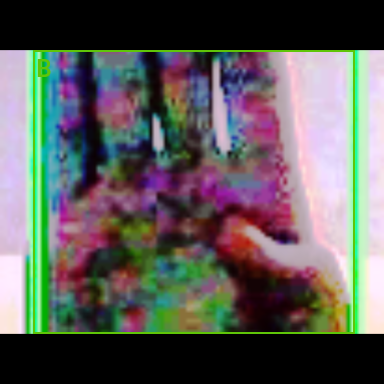

In [30]:
dataset_sample = train_dataset[0]

annotated_tensor = draw_bboxes(
    image=(denorm_img_tensor(dataset_sample[0].cpu(), *norm_stats)*255).to(dtype=torch.uint8), 
    boxes=dataset_sample[1]['boxes'], 
    labels=[class_names[int(i.item())] for i in dataset_sample[1]['labels']], 
    colors=[int_colors[int(i.item())] for i in dataset_sample[1]['labels']]
)

tensor_to_pil(annotated_tensor)

#### Inspect validation set sample

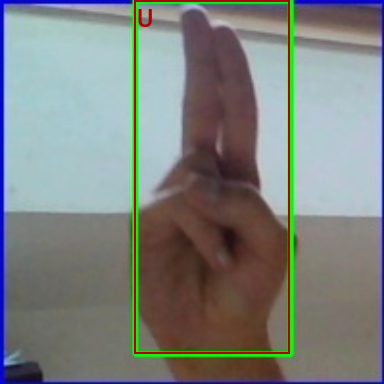

In [31]:
dataset_sample = valid_dataset[0]

annotated_tensor = draw_bboxes(
    image=(denorm_img_tensor(dataset_sample[0].cpu(), *norm_stats)*255).to(dtype=torch.uint8), 
    boxes=dataset_sample[1]['boxes'], 
    labels=[class_names[int(i.item())] for i in dataset_sample[1]['labels']], 
    colors=[int_colors[int(i.item())] for i in dataset_sample[1]['labels']]
)

tensor_to_pil(annotated_tensor)

### Initialize DataLoaders

In [32]:
from windows_utils import tuple_batch

In [33]:
# Set the training batch size
bs = 32

# Set the number of worker processes for loading data.
num_workers = multiprocessing.cpu_count()//2

# Define parameters for DataLoader
data_loader_params = {
    'batch_size': bs,  # Batch size for data loading
    'num_workers': num_workers,  # Number of subprocesses to use for data loading
    'collate_fn': tuple_batch,
    'drop_last': True,
    'pin_memory': 'cuda' in device,
    'pin_memory_device': device if 'cuda' in device else ''
}

# Create DataLoader for training data. Data is shuffled for every epoch.
train_dataloader = DataLoader(train_dataset, **data_loader_params, shuffle=True)

# Create DataLoader for validation data. Shuffling is not necessary for validation data.
valid_dataloader = DataLoader(valid_dataset, **data_loader_params)

# Print the number of batches in the training and validation DataLoaders
pd.Series({
    'Number of batches in train DataLoader:': len(train_dataloader),
    'Number of batches in validation DataLoader:': len(valid_dataloader)}
).to_frame().style.hide(axis='columns')

Number of batches in train DataLoader:,3424
Number of batches in validation DataLoader:,380


## Fine-tuning the Model

### Define the Training Loop

In [34]:
def run_epoch(model, dataloader, optimizer, lr_scheduler, loss_func, device, scaler, epoch_id, is_training):
    """
    Function to run a single training or evaluation epoch.
    
    Args:
        model: A PyTorch model to train or evaluate.
        dataloader: A PyTorch DataLoader providing the data.
        optimizer: The optimizer to use for training the model.
        loss_func: The loss function used for training.
        device: The device (CPU or GPU) to run the model on.
        scaler: Gradient scaler for mixed-precision training.
        is_training: Boolean flag indicating whether the model is in training or evaluation mode.
    
    Returns:
        The average loss for the epoch.
    """
    # Set the model to training mode if is_training is True, otherwise set it to evaluation mode
    model.train() if is_training else model.eval()
    
    epoch_loss = 0  # Initialize the total loss for this epoch
    progress_bar = tqdm(total=len(dataloader), desc="Train" if is_training else "Eval")  # Initialize a progress bar
    
    # Loop over the data
    for batch_id, (inputs, targets) in enumerate(dataloader):
        # Move inputs and targets to the specified device
        inputs = torch.stack(inputs).to(device)
        # Extract the ground truth bounding boxes and labels
        gt_bboxes, gt_labels = zip(*[(d['boxes'].to(device), d['labels'].to(device)) for d in targets])

        # Forward pass with Automatic Mixed Precision (AMP) context manager
        with autocast(torch.device(device).type):
            cls_scores, bbox_preds, objectnesses = model(inputs)
        
            # Compute the loss
            losses = loss_func(cls_scores, bbox_preds, objectnesses, gt_bboxes, gt_labels)
            loss = sum([loss for loss in losses.values()])  # Sum up the losses

        # If in training mode, backpropagate the error and update the weights
        if is_training:
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                old_scaler = scaler.get_scale()
                scaler.update()
                new_scaler = scaler.get_scale()
                if new_scaler >= old_scaler:
                    lr_scheduler.step()
            else:
                loss.backward()
                optimizer.step()
                lr_scheduler.step()
                
            optimizer.zero_grad()

        # Update the total loss
        loss_item = loss.item()
        epoch_loss += loss_item
        
        # Update the progress bar
        progress_bar_dict = dict(loss=loss_item, avg_loss=epoch_loss/(batch_id+1))
        if is_training:
            progress_bar_dict.update(lr=lr_scheduler.get_last_lr()[0])
        progress_bar.set_postfix(progress_bar_dict)
        progress_bar.update()

        # If loss is NaN or infinity, stop training
        if is_training:
            stop_training_message = f"Loss is NaN or infinite at epoch {epoch_id}, batch {batch_id}. Stopping training."
            assert not math.isnan(loss_item) and math.isfinite(loss_item), stop_training_message

    # Cleanup and close the progress bar 
    progress_bar.close()
    
    # Return the average loss for this epoch
    return epoch_loss / (batch_id + 1)

def train_loop(model, 
               train_dataloader, 
               valid_dataloader, 
               optimizer, 
               loss_func, 
               lr_scheduler, 
               device, 
               epochs, 
               checkpoint_path, 
               use_scaler=False):
    """
    Main training loop.
    
    Args:
        model: A PyTorch model to train.
        train_dataloader: A PyTorch DataLoader providing the training data.
        valid_dataloader: A PyTorch DataLoader providing the validation data.
        optimizer: The optimizer to use for training the model.
        loss_func: The loss function used for training.
        lr_scheduler: The learning rate scheduler.
        device: The device (CPU or GPU) to run the model on.
        epochs: The number of epochs to train for.
        checkpoint_path: The path where to save the best model checkpoint.
        use_scaler: Whether to scale graidents when using a CUDA device
    
    Returns:
        None
    """
    # Initialize a gradient scaler for mixed-precision training if the device is a CUDA GPU
    scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' and use_scaler else None
    best_loss = float('inf')  # Initialize the best validation loss

    # Loop over the epochs
    for epoch in tqdm(range(epochs), desc="Epochs"):
        # Run a training epoch and get the training loss
        train_loss = run_epoch(model, train_dataloader, optimizer, lr_scheduler, loss_func, device, scaler, epoch, is_training=True)
        # Run an evaluation epoch and get the validation loss
        with torch.no_grad():
            valid_loss = run_epoch(model, valid_dataloader, None, None, loss_func, device, scaler, epoch, is_training=False)

        # If the validation loss is lower than the best validation loss seen so far, save the model checkpoint
        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), checkpoint_path)

            # Save metadata about the training process
            training_metadata = {
                'epoch': epoch,
                'train_loss': train_loss,
                'valid_loss': valid_loss, 
                'learning_rate': lr_scheduler.get_last_lr()[0],
                'model_architecture': model.name
            }
            with open(Path(checkpoint_path.parent/'training_metadata.json'), 'w') as f:
                json.dump(training_metadata, f)

    # If the device is a GPU, empty the cache
    if device.type != 'cpu':
        getattr(torch, device.type).empty_cache()

### Set the Model Checkpoint Path

In [35]:
# Generate timestamp for the training session (Year-Month-Day_Hour_Minute_Second)
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Create a directory to store the checkpoints if it does not already exist
checkpoint_dir = Path(project_dir/f"{timestamp}")

# Create the checkpoint directory if it does not already exist
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# The model checkpoint path
checkpoint_path = checkpoint_dir/f"{model.name}.pth"

print(checkpoint_path)

pytorch-yolox-object-detector\2024-04-07_22-17-56\yolox_tiny.pth


### Save the Normalization Stats

In [36]:
# Convert tuples to dictionaries for easier JSON representation
norm_stats_dict = {"mean": norm_stats[0], "std_dev": norm_stats[1]}

# Export to JSON
with open(f"{checkpoint_dir}/norm_stats.json", "w") as f:
    json.dump(norm_stats_dict, f)

# Print the name of the file that the normalization stats were written to
print(f"{checkpoint_dir}/norm_stats.json")

pytorch-yolox-object-detector\2024-04-07_22-17-56/norm_stats.json


### Save the Color Map

In [37]:
# Create a color map and write it to a JSON file
color_map = {'items': [{'label': label, 'color': color} for label, color in zip(class_names, colors)]}
with open(f"{checkpoint_dir}/{dataset_path.name}-colormap.json", "w") as file:
    json.dump(color_map, file)

# Print the name of the file that the color map was written to
print(f"{checkpoint_dir}/{dataset_path.name}-colormap.json")

pytorch-yolox-object-detector\2024-04-07_22-17-56/dataset-colormap.json


### Configure the Training Parameters

In [38]:
# Learning rate for the model
lr = 7e-4

# Number of training epochs
epochs = 10

# AdamW optimizer; includes weight decay for regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# Learning rate scheduler; adjusts the learning rate during training
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                   max_lr=lr, 
                                                   total_steps=epochs*len(train_dataloader))

# Initialize the loss function for evaluating model predictions
yolox_loss = YOLOXLoss(num_classes=model.bbox_head.cls_out_channels, 
                       bbox_loss_weight=10.0, 
                       use_l1=False)

### Train the Model

In [39]:
train_loop(model=model, 
           train_dataloader=train_dataloader,
           valid_dataloader=valid_dataloader,
           optimizer=optimizer, 
           loss_func=yolox_loss, 
           lr_scheduler=lr_scheduler, 
           device=torch.device(device), 
           epochs=epochs, 
           checkpoint_path=checkpoint_path,
           use_scaler=True)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/3424 [00:00<?, ?it/s]

Eval:   0%|          | 0/380 [00:00<?, ?it/s]

Train:   0%|          | 0/3424 [00:00<?, ?it/s]

Eval:   0%|          | 0/380 [00:00<?, ?it/s]

Train:   0%|          | 0/3424 [00:00<?, ?it/s]

Eval:   0%|          | 0/380 [00:00<?, ?it/s]

Train:   0%|          | 0/3424 [00:00<?, ?it/s]

Eval:   0%|          | 0/380 [00:00<?, ?it/s]

Train:   0%|          | 0/3424 [00:00<?, ?it/s]

Eval:   0%|          | 0/380 [00:00<?, ?it/s]

Train:   0%|          | 0/3424 [00:00<?, ?it/s]

Eval:   0%|          | 0/380 [00:00<?, ?it/s]

Train:   0%|          | 0/3424 [00:00<?, ?it/s]

Eval:   0%|          | 0/380 [00:00<?, ?it/s]

Train:   0%|          | 0/3424 [00:00<?, ?it/s]

Eval:   0%|          | 0/380 [00:00<?, ?it/s]

Train:   0%|          | 0/3424 [00:00<?, ?it/s]

Eval:   0%|          | 0/380 [00:00<?, ?it/s]

Train:   0%|          | 0/3424 [00:00<?, ?it/s]

Eval:   0%|          | 0/380 [00:00<?, ?it/s]

## Making Predictions with the Model

### Preparing the Model for Inference

#### Wrap the model with preprocessing and post-processing steps

In [48]:
# Convert the normalization stats to tensors
mean_tensor = torch.tensor(norm_stats[0]).view(1, 3, 1, 1)
std_tensor = torch.tensor(norm_stats[1]).view(1, 3, 1, 1)

# Set the model to evaluation mode
model.eval()

# Wrap the model with preprocessing and post-processing steps
wrapped_model = YOLOXInferenceWrapper(model, mean_tensor, std_tensor).to(device=device)

### Preparing Input Data

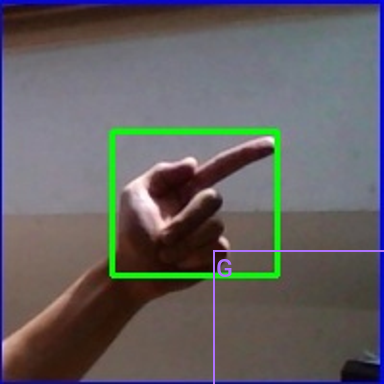

Resized Image Size:,"(384, 384)"
Input Dims:,"[384, 384]"
Offsets:,[0. 0.]
Min Image Scale:,0.520833
Input Image Size:,"(384, 384)"
Target BBoxes:,['G:[213.811 250.675 317.03 276.48 ]']


In [58]:
# Choose a random item from the validation set
file_id = random.choice(val_keys)

# Retrieve the image file path associated with the file ID
test_file = img_dict[file_id]

# Open the test file
test_img = Image.open(test_file).convert('RGB')

# Resize the test image
resized_img = resize_img(test_img, target_sz=train_sz, divisor=1)

# Ensure the input dimensions are multiples of the max stride
input_dims = [dim - dim % max(strides) for dim in resized_img.size]

# Calculate the offsets from the resized image dimensions to the input dimensions
offsets = (np.array(resized_img.size) - input_dims)/2

# Calculate the scale between the source image and the resized image
min_img_scale = min(test_img.size) / min(resized_img.size)

# Crop the resized image to the input dimensions
input_img = resized_img.crop(box=[*offsets, *resized_img.size-offsets])

# Get the target labels and bounding boxes
target_labels = annotation_df.loc[file_id]['labels']
target_bboxes = annotation_df.loc[file_id]['bboxes']

# Scale bounding boxes according to image dimensions
target_bboxes = [bbox*(resized_img.size*2) for bbox in target_bboxes]
# Offset bounding boxes according to input dimensions
target_bboxes = np.array([bbox/min_img_scale-[*offsets, 0, 0] for bbox in target_bboxes])

# Create a tensor from the test image and annotate it
annotated_tensor = draw_bboxes(
    image=transforms.PILToTensor()(input_img), 
    boxes=torchvision.ops.box_convert(torch.Tensor(target_bboxes), 'xywh', 'xyxy'), 
    labels=target_labels, 
    colors=[int_colors[i] for i in [class_names.index(label) for label in target_labels]]
)

# Display the annotated test image
annotated_test_img = tensor_to_pil(annotated_tensor)
display(annotated_test_img)

# Print the prediction data as a Pandas DataFrame for easy formatting
pd.Series({
    "Resized Image Size:": resized_img.size,
    "Input Dims:": input_dims,
    "Offsets:": offsets,
    "Min Image Scale:": min_img_scale,
    "Input Image Size:": input_img.size, 
    "Target BBoxes:": [f"{label}:{bbox}" for label, bbox in zip(target_labels, np.round(target_bboxes, decimals=3))]
}).to_frame().style.hide(axis='columns')

#### Pass the input data to the model

In [59]:
# Ensure the model and input data are on the same device
wrapped_model.to(device);
input_tensor = transforms.Compose([transforms.ToImage(), 
                                   transforms.ToDtype(torch.float32, scale=True)])(input_img)[None].to(device)

# Make a prediction with the model
with torch.no_grad():
    model_output = wrapped_model(input_tensor)

model_output.shape

torch.Size([1, 3024, 6])

### Filtering Model Output

In [60]:
# Set the bounding box confidence threshold
bbox_conf_thresh = 0.4

# Move model output to the CPU
model_output = model_output.to('cpu')

# Filter the proposals based on the confidence threshold
max_probs = model_output[:, : ,-1]
mask = max_probs > bbox_conf_thresh
proposals = model_output[mask]

# Sort the proposals by probability in descending order
proposals = proposals[proposals[..., -1].argsort(descending=True)]

# Set the non-max suppression threshold
iou_thresh = 0.45

# Filter bouning box proposals using NMS
proposal_indices = torchvision.ops.nms(
    boxes=torchvision.ops.box_convert(proposals[:, :-2], 'xywh', 'xyxy'), 
    scores=proposals[:, -1], 
    iou_threshold=iou_thresh
)
proposals = proposals[proposal_indices]

# Convert the proposals to a Pandas DataFrame
proposals_df = pd.DataFrame([
    {'x0': x0, 'y0': y0, 'width': w, 'height': h, 'label': label, 'prob': prob} 
    for x0, y0, w, h, label, prob in proposals.numpy()
])

if len(proposals_df) > 0:
    # Add the label names to the DataFrame
    proposals_df['label'] = proposals_df['label'].apply(lambda x: class_names[int(x)])

# Print the proposals Dataframe
proposals_df

,x0,y0,width,height,label,prob
0,111.329926,130.692825,165.223083,143.847443,G,0.996451


#### Annotate image using bounding box proposals

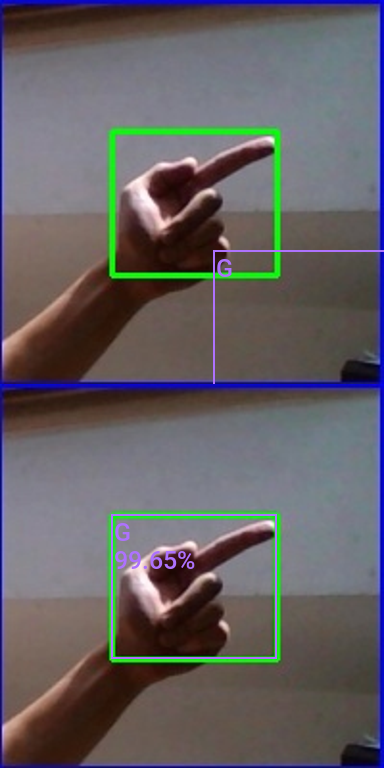

Target BBoxes:,['G:[213.811 250.675 317.03 276.48 ]']
Predicted BBoxes:,['G:[111.33 130.693 165.223 143.847]']
Confidence Scores:,['G: 99.65%']


In [65]:
# Extract x0, y0, width, height columns
pred_bboxes = proposals[:,:-2]

# Extract label and prob columns as lists
pred_labels = [class_names[int(idx)] for idx in proposals[:,4]]
pred_probs = proposals[:,5]

annotated_tensor = draw_bboxes(
    image=transforms.PILToTensor()(input_img), 
    boxes=torchvision.ops.box_convert(pred_bboxes, 'xywh', 'xyxy'), 
    labels=[f"{label}\n{prob*100:.2f}%" for label, prob in zip(pred_labels, pred_probs)], 
    colors=[int_colors[class_names.index(i)] for i in pred_labels]
)

# Display the annotated test image with the predicted bounding boxes
display(stack_imgs([annotated_test_img, tensor_to_pil(annotated_tensor)]))

# Print the prediction data as a Pandas DataFrame for easy formatting
pd.Series({
    "Target BBoxes:": [f"{label}:{bbox}" for label, bbox in zip(target_labels, np.round(target_bboxes, decimals=3))],
    "Predicted BBoxes:": [f"{label}:{bbox}" for label, bbox in zip(pred_labels, pred_bboxes.round(decimals=3).numpy())],
    "Confidence Scores:": [f"{label}: {prob*100:.2f}%" for label, prob in zip(pred_labels, pred_probs)]
}).to_frame().style.hide(axis='columns')

### Testing the Model on New Data

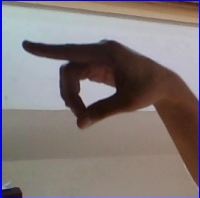

Test Image Size:,"(200, 200)"
Cropped Image Size:,"(200, 198)"


In [81]:
test_img_name = "dataset/test/P_test.jpg"
test_img = Image.open(test_img_name)
original_size = test_img.size

# Crop test image so it's height is not a multiple of the max stride
test_img = test_img.crop(box=[0, 1, test_img.width, test_img.height-1])
display(test_img)

pd.Series({
    "Test Image Size:": original_size, 
    "Cropped Image Size:": test_img.size
}).to_frame().style.hide(axis='columns')

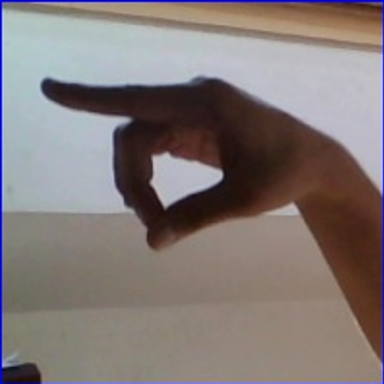

Resized Image Size:,"(387, 384)"
Input Dims:,"[384, 384]"
Offsets:,[1.5 0. ]
Min Image Scale:,0.515625
Input Image Size:,"(384, 384)"


In [82]:
# Resize image without cropping to multiple of the max stride
resized_img = resize_img(test_img, target_sz=train_sz, divisor=1)

# Calculating the input dimensions that multiples of the max stride
input_dims = [dim - dim % max(strides) for dim in resized_img.size]

# Calculate the offsets from the resized image dimensions to the input dimensions
offsets = (np.array(resized_img.size) - input_dims)/2

# Calculate the scale between the source image and the resized image
min_img_scale = min(test_img.size) / min(resized_img.size)

# Crop the resized image to the input dimensions
input_img = resized_img.crop(box=[*offsets, *resized_img.size-offsets])

display(input_img)

pd.Series({
    "Resized Image Size:": resized_img.size,
    "Input Dims:": input_dims,
    "Offsets:": offsets,
    "Min Image Scale:": min_img_scale,
    "Input Image Size:": input_img.size
}).to_frame().style.hide(axis='columns')

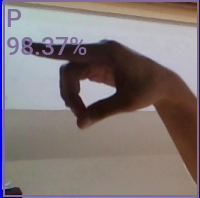

Predicted BBoxes:,['P:[ 3.984 0.407 194.591 196.266]']
Confidence Scores:,['P: 98.37%']


In [83]:
input_tensor = transforms.Compose([transforms.ToImage(), 
                                   transforms.ToDtype(torch.float32, scale=True)])(input_img)[None].to(device)
wrapped_model.to(device)

with torch.no_grad():
    model_output = wrapped_model(input_tensor).to('cpu')

# Filter the proposals based on the confidence threshold
max_probs = model_output[:, : ,-1]
mask = max_probs > bbox_conf_thresh
proposals = model_output[mask]

# Sort the proposals by probability in descending order
proposals = proposals[proposals[..., -1].argsort(descending=True)]

# Filter bouning box proposals using NMS
proposal_indices = torchvision.ops.nms(
    boxes=torchvision.ops.box_convert(proposals[:, :-2], 'xywh', 'xyxy'), 
    scores=proposals[:, -1], 
    iou_threshold=iou_thresh
)
proposals = proposals[proposal_indices]

# Offset and scale the predicted bounding boxes
pred_bboxes = (proposals[:,:4]+torch.Tensor([*offsets, 0, 0]))*min_img_scale

# Extract label and prob columns as lists
pred_labels = [class_names[int(idx)] for idx in proposals[:,4]]
pred_probs = proposals[:,5]

annotated_tensor = draw_bboxes(
    image=transforms.PILToTensor()(test_img), 
    boxes=torchvision.ops.box_convert(torch.Tensor(pred_bboxes), 'xywh', 'xyxy'), 
    labels=[f"{label}\n{prob*100:.2f}%" for label, prob in zip(pred_labels, pred_probs)], 
    colors=[int_colors[class_names.index(i)] for i in pred_labels]
)

display(tensor_to_pil(annotated_tensor))

# Print the prediction data as a Pandas Series for easy formatting
pd.Series({
    "Predicted BBoxes:": [f"{label}:{bbox}" for label, bbox in zip(pred_labels, pred_bboxes.round(decimals=3).numpy())],
    "Confidence Scores:": [f"{label}: {prob*100:.2f}%" for label, prob in zip(pred_labels, pred_probs)]
}).to_frame().style.hide(axis='columns')